In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [31]:
# Import the excel spreadsheets in the data folder
installer_df = pd.read_excel('../data/Installer.xlsx')
involver_df = pd.read_excel('../data/Involver.xlsx')

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [32]:
# Attempt to merge using a subset of key columns
merge_on_columns = ['Site', 'Vessel_Name', 'Wo_No']

df = pd.concat([installer_df, involver_df], axis=0)

feature_columns = ['Group', 'Symptom', 'Error_Cause', 'Cause_Details', 'Error_Class', 'Discovery', 'Completion_Note', 'Action_Taken', 'Work_Description', 'Directive']
target_column = 'CaseReviewed'

# Filter the dataframe for the selected columns
df = df[feature_columns + [target_column]].dropna()

In [33]:
# Convert the target column to ids 
# Encode the target column
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column].astype(str))
df[target_column].dtype, df[target_column].unique()

(dtype('int64'), array([3, 1, 5, 7, 6, 0, 2, 4]))

In [34]:
# Define the TF-IDF vectorizer for text columns
preprocessor = ColumnTransformer(
    transformers=[
        (col, TfidfVectorizer(), col) for col in feature_columns
    ], remainder='drop'  # Dropping non-specified columns, though all columns are specified here
)

# Create a pipeline with preprocessor, scaler, and MLPClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # Apply scaler after TF-IDF transformation
    ('classifier', MLPClassifier(random_state=42, verbose=True))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__hidden_layer_sizes': [(50, 50), (100,), (100, 50), (100, 100)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [200, 500]
}

# Split the data into training and testing sets
X = df[feature_columns]
y = df[target_column]

# Check if the length of X and y are consistent
assert len(X) == len(y), "Mismatch in the number of samples between X and y"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples: ", X_train.shape, "Testing samples: ", X_test.shape)
print("Training labels: ", y_train.shape, "Testing labels: ", y_test.shape)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

Training samples:  (549, 10) Testing samples:  (138, 10)
Training labels:  (549,) Testing labels:  (138,)
Fitting 3 folds for each of 192 candidates, totalling 576 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Iteration 1, loss = 2.12974999
Iteration 2, loss = 2.11055944
Iteration 3, loss = 2.08186655
Iteration 4, loss = 2.04683390
Iteration 5, loss = 2.00873866
Iteration 6, loss = 1.96856802
Iteration 7, loss = 1.92914530
Iteration 8, loss = 1.88968295
Iteration 9, loss = 1.85128815
Iteration 10, loss = 1.81562332
Iteration 11, loss = 1.78023072
Iteration 12, loss = 1.74797777
Iteration 13, loss = 1.71684816
Iteration 14, loss = 1.68807681
Iteration 15, loss = 1.66033550
Iteration 16, loss = 1.63455948
Iteration 17, loss = 1.61062038
Iteration 18, loss = 1.58788353
Iteration 19, loss = 1.56616445
Iteration 20, loss = 1.54655154
Iteration 21, loss = 1.52778680
Iteration 22, loss = 1.50978435
Iteration 23, loss = 1.49307478
Iteration 24, loss = 1.47699516
Iteration 25, loss = 1.46186635
Iteration 26, loss = 1.44764771
Iteration 27, loss = 1.43371739
Iteration 28, loss = 1.42083343
Iteration 29, loss = 1.40832251
Iteration 30, loss = 1.39633586
Iteration 31, loss = 1.38471695
Iteration 32, los

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Test accuracy:  0.6739130434782609
Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.64      0.68        59
           2       0.57      0.71      0.63        24
           3       1.00      0.45      0.62        11
           5       0.66      0.75      0.70        44

    accuracy                           0.67       138
   macro avg       0.74      0.64      0.66       138
weighted avg       0.70      0.67      0.67       138



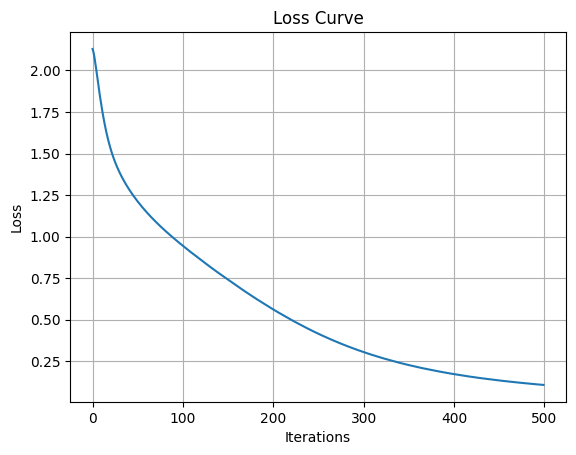

In [35]:
# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
classifier = best_model.named_steps['classifier']
plt.plot(classifier.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()